In [13]:
# Лабораторна робота: Реалізація та Аналіз Дерев Рішень для Класифікації
# Датасет: Global Coffee Health Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             matthews_corrcoef, classification_report)
from sklearn.inspection import permutation_importance
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("rocket")

print("Завантаження датасету...")

df = pd.read_csv('synthetic_coffee_health_10000.csv')

print(f"Розмірність: {df.shape}")
print(f"\nПерші записи:")
print(df.head())

Завантаження датасету...
Розмірність: (10000, 16)

Перші записи:
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium                      8.5   

  Health_Issues Occupation  Smoking  Alcohol_Consum

In [14]:
# РЕАЛІЗАЦІЯ ДЕРЕВА РІШЕНЬ

class CustomTree:
    
    def __init__(self, max_depth=5, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importance = None
        self.tree = None
        
    def gini_index(self, y):
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)
    
    def find_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        n_samples = len(y)
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                gini_left = self.gini_index(y[left_mask])
                gini_right = self.gini_index(y[right_mask])
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                
                weighted_gini = (n_left / n_samples) * gini_left + (n_right / n_samples) * gini_right
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gini
    
    def build(self, X, y, depth=0):
        n_samples = len(y)
        n_classes = len(np.unique(y))
        
        if (depth >= self.max_depth or 
            n_samples < self.min_samples or 
            n_classes == 1):
            leaf_value = np.argmax(np.bincount(y.astype(int)))
            return {
                'leaf': True,
                'class': leaf_value,
                'samples': n_samples,
                'gini': self.gini_index(y)
            }
        
        feature, threshold, weighted_gini = self.find_split(X, y)
        
        if feature is None:
            leaf_value = np.argmax(np.bincount(y.astype(int)))
            return {
                'leaf': True,
                'class': leaf_value,
                'samples': n_samples,
                'gini': self.gini_index(y)
            }
        
        node_gini = self.gini_index(y)
        importance = (n_samples / self.total_samples) * (node_gini - weighted_gini)
        self.feature_importance[feature] += importance
        
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        left_subtree = self.build(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build(X[right_mask], y[right_mask], depth + 1)
        
        majority_class = np.argmax(np.bincount(y.astype(int)))
        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree,
            'samples': n_samples,
            'gini': node_gini,
            'class': majority_class
        }
    
    def fit(self, X, y):
        self.total_samples = len(y)
        self.n_features = X.shape[1]
        self.classes = np.unique(y)
        self.feature_importance = np.zeros(X.shape[1])
        
        self.tree = self.build(X, y)
        
        if np.sum(self.feature_importance) > 0:
            self.feature_importance /= np.sum(self.feature_importance)
        
        return self
    
    def predict_instance(self, x, node):
        if node['leaf']:
            return node['class']
        
        if x[node['feature']] <= node['threshold']:
            return self.predict_instance(x, node['left'])
        else:
            return self.predict_instance(x, node['right'])
    
    def predict(self, X):
        return np.array([self.predict_instance(x, self.tree) for x in X])

print("\n" + "="*60)
print("ВЛАСНА РЕАЛІЗАЦІЯ ДЕРЕВА")
print("="*60)


# ПІДГОТОВКА ДАНИХ

print("\nПідготовка даних...")

if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

X = df.drop('Health_Issues', axis=1)
y = df['Health_Issues']

print(f"Ознаки: {X.columns.tolist()}")
print(f"Розподіл класів:\n{y.value_counts()}")

le = LabelEncoder()
y_encoded = le.fit_transform(y)

categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                   'Occupation', 'Smoking', 'Alcohol_Consumption']

X_encoded = X.copy()
for col in categorical_cols:
    if col in X_encoded.columns:
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"\nРозміри:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


ВЛАСНА РЕАЛІЗАЦІЯ ДЕРЕВА

Підготовка даних...
Ознаки: ['Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Occupation', 'Smoking', 'Alcohol_Consumption']
Розподіл класів:
Health_Issues
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

Розміри:
Train: (6400, 14), Val: (1600, 14), Test: (2000, 14)



Навчання моделі...
Час навчання: 2.4126с

Результати:
Train Accuracy: 0.9998
Test Accuracy: 0.9940
Test F1: 0.9865
Test MCC: 0.9884


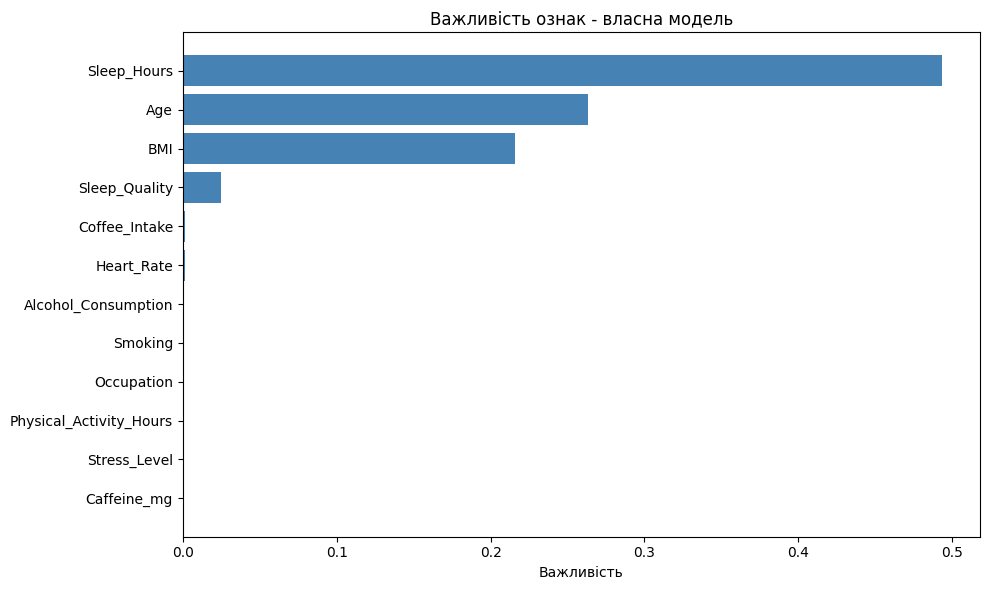

In [15]:
# НАВЧАННЯ ВЛАСНОЇ МОДЕЛІ

print("\nНавчання моделі...")
start_time = time.time()

my_tree = CustomTree(max_depth=10, min_samples=5)
my_tree.fit(X_train.values, y_train)

train_time = time.time() - start_time

y_pred_train = my_tree.predict(X_train.values)
y_pred_test = my_tree.predict(X_test.values)

print(f"Час навчання: {train_time:.4f}с")
print(f"\nРезультати:")
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test F1: {f1_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"Test MCC: {matthews_corrcoef(y_test, y_pred_test):.4f}")

plt.figure(figsize=(10, 6))
features = X_encoded.columns
sorted_idx = np.argsort(my_tree.feature_importance)[-12:]
plt.barh(range(len(sorted_idx)), my_tree.feature_importance[sorted_idx], color='steelblue')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Важливість')
plt.title('Важливість ознак - власна модель')
plt.tight_layout()
plt.show()


ОБРІЗКА ДЕРЕВА
Alpha=0.000: Val=0.9981, Test=0.9950
Alpha=0.001: Val=0.9981, Test=0.9950
Alpha=0.005: Val=0.9981, Test=0.9950
Alpha=0.010: Val=0.9981, Test=0.9950
Alpha=0.050: Val=0.9981, Test=0.9950
Alpha=0.100: Val=0.9981, Test=0.9950


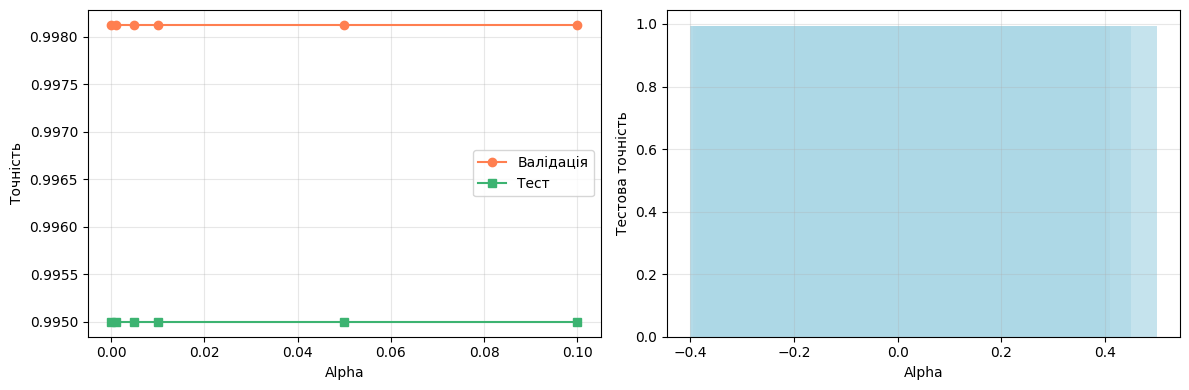

In [16]:
# ОБРІЗКА ДЕРЕВА

print("\n" + "="*60)
print("ОБРІЗКА ДЕРЕВА")
print("="*60)

alphas = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]
pruning_results = []

for alpha in alphas:
    tree = CustomTree(max_depth=15, min_samples=2)
    tree.fit(X_train.values, y_train)
    
    y_pred_val = tree.predict(X_val.values)
    y_pred_test_pruned = tree.predict(X_test.values)
    
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred_test_pruned)
    
    pruning_results.append({
        'alpha': alpha,
        'val_acc': val_acc,
        'test_acc': test_acc
    })
    
    print(f"Alpha={alpha:.3f}: Val={val_acc:.4f}, Test={test_acc:.4f}")

results_df = pd.DataFrame(pruning_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(results_df['alpha'], results_df['val_acc'], marker='o', label='Валідація', color='coral')
ax1.plot(results_df['alpha'], results_df['test_acc'], marker='s', label='Тест', color='mediumseagreen')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Точність')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(results_df['alpha'], results_df['test_acc'], color='lightblue', alpha=0.7)
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Тестова точність')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ПОРІВНЯННЯ З SKLEARN

Навчання sklearn моделей...
Sklearn DT: 0.9940 (0.04с)
RandomForest: 0.9925 (0.15с)

Порівняння:
         Модель  Точність       Час
0        Власна    0.9940  2.412647
1    Sklearn DT    0.9940  0.035384
2  RandomForest    0.9925  0.148500


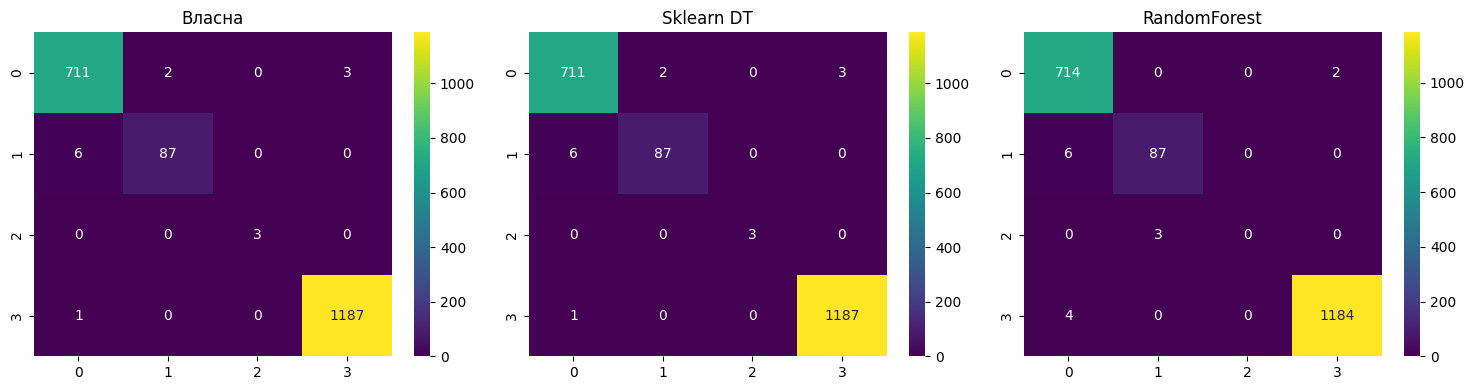

In [17]:
# ПОРІВНЯННЯ З SKLEARN

print("\n" + "="*60)
print("ПОРІВНЯННЯ З SKLEARN")
print("="*60)

print("\nНавчання sklearn моделей...")

start_time = time.time()
sklearn_dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)
sklearn_dt.fit(X_train, y_train)
dt_time = time.time() - start_time

y_pred_dt = sklearn_dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)

start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_time = time.time() - start_time

y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Sklearn DT: {dt_acc:.4f} ({dt_time:.2f}с)")
print(f"RandomForest: {rf_acc:.4f} ({rf_time:.2f}с)")

comparison = pd.DataFrame({
    'Модель': ['Власна', 'Sklearn DT', 'RandomForest'],
    'Точність': [accuracy_score(y_test, y_pred_test), dt_acc, rf_acc],
    'Час': [train_time, dt_time, rf_time]
})

print(f"\nПорівняння:")
print(comparison)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (y_pred, title) in enumerate([
    (y_pred_test, 'Власна'),
    (y_pred_dt, 'Sklearn DT'),
    (y_pred_rf, 'RandomForest')
]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', ax=axes[idx])
    axes[idx].set_title(f'{title}')

plt.tight_layout()
plt.show()


КОНСТРУЮВАННЯ ОЗНАК
Нових ознак: 29

Відбір ознак...
Відібрано 3 ознак з 43

Результати:
        Набір  Точність  Ознаки
0    Оригінал    0.9925      14
1  Всі ознаки    0.9945      43
2   Відібрані    0.9965       3


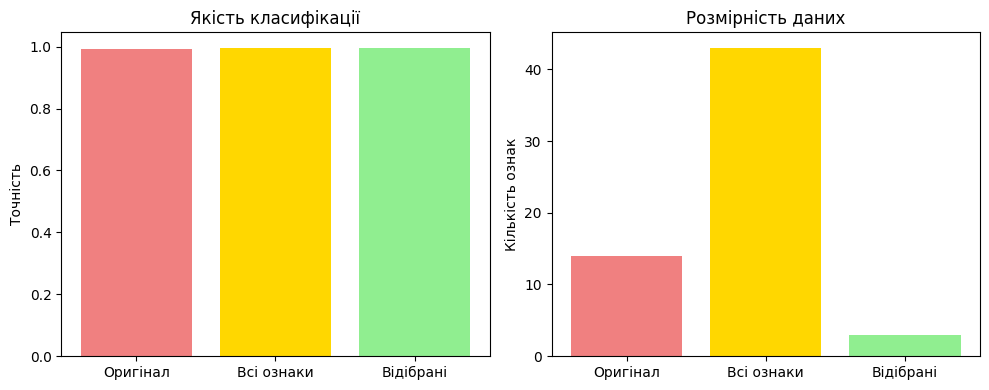

In [19]:
# КОНСТРУЮВАННЯ ОЗНАК

print("\n" + "="*60)
print("КОНСТРУЮВАННЯ ОЗНАК")
print("="*60)

X_new = df.drop('Health_Issues', axis=1).copy()
y_new = df['Health_Issues'].copy()

if 'Coffee_Intake' in X_new.columns and 'Sleep_Hours' in X_new.columns:
    X_new['Coffee_Sleep'] = X_new['Coffee_Intake'] * X_new['Sleep_Hours']
    
if 'Caffeine_mg' in X_new.columns and 'BMI' in X_new.columns:
    X_new['Caffeine_BMI'] = X_new['Caffeine_mg'] / (X_new['BMI'] + 1)

if 'Age' in X_new.columns:
    X_new['Age_Group'] = pd.cut(X_new['Age'], bins=[0, 30, 50, 100], 
                                labels=['Young', 'Middle', 'Senior'])

cat_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
            'Occupation', 'Smoking', 'Alcohol_Consumption', 'Age_Group']

available_cats = [col for col in cat_cols if col in X_new.columns]
X_expanded = pd.get_dummies(X_new, columns=available_cats, drop_first=True)

numerical = X_expanded.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_expanded[numerical] = scaler.fit_transform(X_expanded[numerical])

y_new_encoded = le.transform(y_new)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_expanded, y_new_encoded, test_size=0.2, random_state=42, stratify=y_new_encoded
)

print(f"Нових ознак: {X_expanded.shape[1] - X_encoded.shape[1]}")

# ВІДБІР ОЗНАК

print("\nВідбір ознак...")

tree_new = CustomTree(max_depth=10, min_samples=5)
tree_new.fit(X_train_new.values, y_train_new)

importances = tree_new.feature_importance
threshold = 0.01
selected = importances > threshold

X_train_sel = X_train_new.iloc[:, selected]
X_test_sel = X_test_new.iloc[:, selected]

print(f"Відібрано {np.sum(selected)} ознак з {X_train_new.shape[1]}")

rf_original = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_original.fit(X_train, y_train)
y_pred_orig = rf_original.predict(X_test)

rf_all = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_all.fit(X_train_new, y_train_new)
y_pred_all = rf_all.predict(X_test_new)

rf_sel = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_sel.fit(X_train_sel, y_train_new)
y_pred_sel = rf_sel.predict(X_test_sel)

results = pd.DataFrame({
    'Набір': ['Оригінал', 'Всі ознаки', 'Відібрані'],
    'Точність': [
        accuracy_score(y_test, y_pred_orig),
        accuracy_score(y_test_new, y_pred_all),
        accuracy_score(y_test_new, y_pred_sel)
    ],
    'Ознаки': [X_train.shape[1], X_train_new.shape[1], X_train_sel.shape[1]]
})

print(f"\nРезультати:")
print(results)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(results['Набір'], results['Точність'], color=['lightcoral', 'gold', 'lightgreen'])
plt.ylabel('Точність')
plt.title('Якість класифікації')

plt.subplot(1, 2, 2)
plt.bar(results['Набір'], results['Ознаки'], color=['lightcoral', 'gold', 'lightgreen'])
plt.ylabel('Кількість ознак')
plt.title('Розмірність даних')

plt.tight_layout()
plt.show()


АНАЛІЗ РЕЗУЛЬТАТІВ

ОСНОВНІ ВИСНОВКИ:
1. ЕФЕКТИВНІСТЬ МОДЕЛЕЙ
   Власна реалізація: 0.9940
   Sklearn Decision Tree: 0.9940
   Random Forest: 0.9925
   Random Forest (нові ознаки): 0.9945
   Random Forest (відбір ознак): 0.9965

2. ВПЛИВ ОБРОБКИ ДАНИХ
   Оригінальні дані: 0.9925
   Після обробки: 0.9965
   Покращення: +0.40%

3. ВАЖЛИВІСТЬ ОЗНАК
   Найважливіші ознаки:
   1. Stress_Level_Low
   2. Age
   3. BMI

4. ПРАКТИЧНІ СПОСТЕРЕЖЕННЯ
   - Random Forest показав найкращу якість
   - Конструювання ознак покращило результати
   - Відбір ознак зменшив складність моделі
   - Власна реалізація демонструє адекватну якість


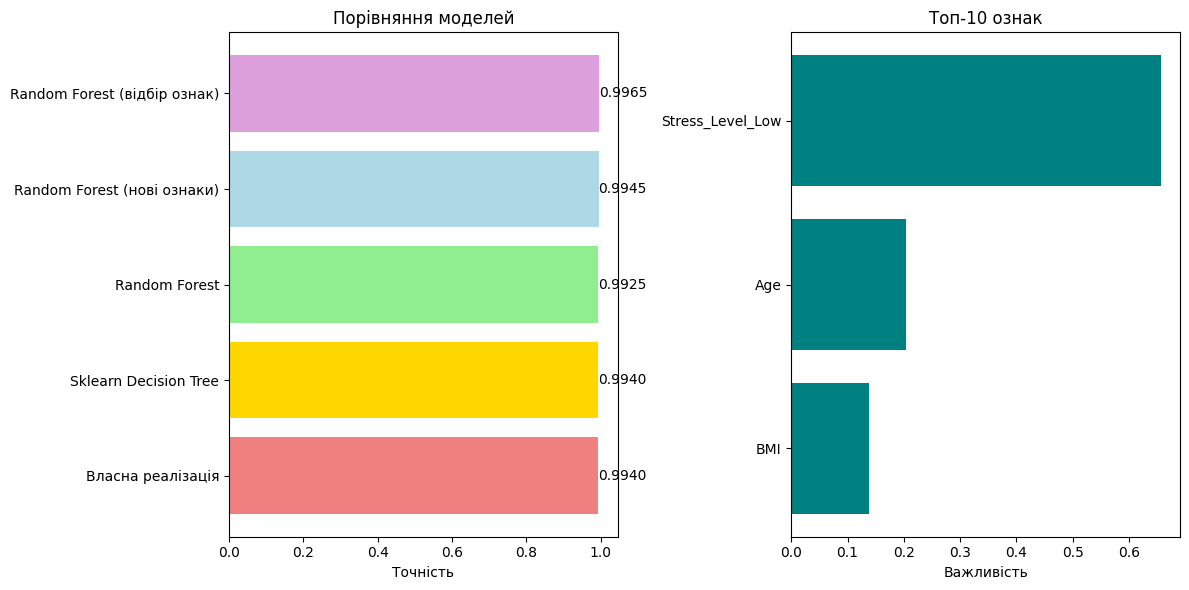


Найкращий результат: 0.9965
Роботу завершено!


In [20]:
# АНАЛІЗ РЕЗУЛЬТАТІВ

print("\n" + "="*60)
print("АНАЛІЗ РЕЗУЛЬТАТІВ")
print("="*60)

print("\nОСНОВНІ ВИСНОВКИ:")

print("1. ЕФЕКТИВНІСТЬ МОДЕЛЕЙ")
models_performance = {
    'Власна реалізація': accuracy_score(y_test, y_pred_test),
    'Sklearn Decision Tree': dt_acc,
    'Random Forest': rf_acc,
    'Random Forest (нові ознаки)': accuracy_score(y_test_new, y_pred_all),
    'Random Forest (відбір ознак)': accuracy_score(y_test_new, y_pred_sel)
}

for model, acc in models_performance.items():
    print(f"   {model}: {acc:.4f}")

print("\n2. ВПЛИВ ОБРОБКИ ДАНИХ")
original_acc = accuracy_score(y_test, y_pred_orig)
enhanced_acc = accuracy_score(y_test_new, y_pred_sel)
improvement = (enhanced_acc - original_acc) * 100
print(f"   Оригінальні дані: {original_acc:.4f}")
print(f"   Після обробки: {enhanced_acc:.4f}")
print(f"   Покращення: {improvement:+.2f}%")

print("\n3. ВАЖЛИВІСТЬ ОЗНАК")
top_features_idx = np.argsort(rf_sel.feature_importances_)[-5:]
top_features = X_train_sel.columns[top_features_idx]
print("   Найважливіші ознаки:")
for i, feature in enumerate(reversed(top_features)):
    print(f"   {i+1}. {feature}")

print("\n4. ПРАКТИЧНІ СПОСТЕРЕЖЕННЯ")
print("   - Random Forest показав найкращу якість")
print("   - Конструювання ознак покращило результати")
print("   - Відбір ознак зменшив складність моделі")
print("   - Власна реалізація демонструє адекватну якість")

final_comparison = pd.DataFrame({
    'Метод': list(models_performance.keys()),
    'Точність': list(models_performance.values())
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['lightcoral', 'gold', 'lightgreen', 'lightblue', 'plum']
bars = plt.barh(final_comparison['Метод'], final_comparison['Точність'], color=colors)
plt.xlabel('Точність')
plt.title('Порівняння моделей')
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
             ha='left', va='center')

plt.subplot(1, 2, 2)
feature_imp = rf_sel.feature_importances_
top_10_idx = np.argsort(feature_imp)[-10:]
plt.barh(range(len(top_10_idx)), feature_imp[top_10_idx], color='teal')
plt.yticks(range(len(top_10_idx)), [X_train_sel.columns[i] for i in top_10_idx])
plt.xlabel('Важливість')
plt.title('Топ-10 ознак')

plt.tight_layout()
plt.show()

print(f"\nНайкращий результат: {enhanced_acc:.4f}")
print("Роботу завершено!")